# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [372]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [373]:
df = pd.read_csv("data/spam_or_not_spam.csv")
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [374]:
df['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

In [375]:
df['label'].value_counts(normalize=True)

0    0.833333
1    0.166667
Name: label, dtype: float64

<AxesSubplot: xlabel='label', ylabel='count'>

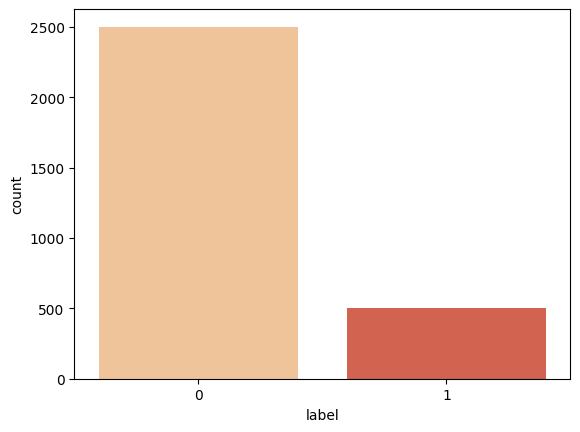

In [376]:
sns.countplot(data=df, x='label', palette = 'OrRd')

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [377]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [378]:
df.loc[df['email'] == ' ', 'email'] = np.nan 
df.loc[df['email'] == '', 'email'] = np.nan       
df = df.dropna()

Переводим данные в векторный вид:

In [379]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['email'])

Определите, сколько теперь признаков в нашем наборе данных:

In [380]:
X.shape

(2997, 34116)

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [381]:
y = df["label"]

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [383]:
y_test.mean().round(3)

0.165

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [384]:
clf = MultinomialNB(alpha = 0.01)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [385]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Precision: {precision_score(y_test, y_test_pred)}")

Accuracy: 0.9866666666666667
Precision: 1.0


Нарисуйте ROC-кривую:

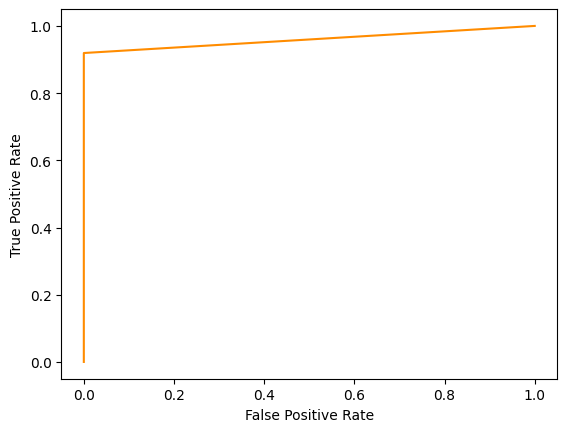

In [386]:
fpr, tpr, _ = metrics.roc_curve (y_test, y_test_pred)

#ROC кривая
plt.plot (fpr,tpr, color='darkorange')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [417]:
from sklearn import model_selection

# создадим функцию, которая будет принимать датасет и уровень альфа, 
# а выводить метрику accuracy с помощью кросс-валидации на 5 фолдах 
def clf_cv(X_train, y_train, alpha):
    for i, value in enumerate(alpha):
        clf = MultinomialNB(alpha = value)
        cv_metrics = model_selection.cross_validate(
        estimator=clf, #модель
        X=X_train, #матрица наблюдений X
        y=y_train, #вектор ответов y
        cv=model_selection.KFold(n_splits=5), #кросс-валидатор
        scoring='accuracy', #метрика
        return_train_score=True) #подсчёт метрики на тренировочных фолдах
        print(f"Train k-fold accuracy for α = {value}: {round(np.mean(cv_metrics['train_score']), 4)}" )  
        print(f"Valid k-fold accuracy for α = {value}: {round(np.mean(cv_metrics['test_score']), 4)}")
        print('')
# проверим значение метрики accuracy при разных уровнях альфа:
alpha = [0.001, 0.1, 1, 10, 100]
clf_cv(X_train, y_train, alpha)   


Train k-fold accuracy for α = 0.001: 0.9989
Valid k-fold accuracy for α = 0.001: 0.9862

Train k-fold accuracy for α = 0.1: 0.9989
Valid k-fold accuracy for α = 0.1: 0.9915

Train k-fold accuracy for α = 1: 0.9976
Valid k-fold accuracy for α = 1: 0.9907

Train k-fold accuracy for α = 10: 0.8834
Valid k-fold accuracy for α = 10: 0.8785

Train k-fold accuracy for α = 100: 0.843
Valid k-fold accuracy for α = 100: 0.8433



Видим, что при разных уровнях альфа метрика accuracy везде высокая, и вплоть до альфа, равного 1, она отличается только третьими знаками после 
запятой. А начиная с α = 10, ее уровень начинает снижаться.То есть качество предсказания медленно и довольно плавно, но ухудшается с увеличением α.
